In [333]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os 
import pandas as pd
from scipy import signal, fft
from datetime import datetime
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, AffinityPropagation
from signaltk import constants as cst
from scipy.signal import detrend

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

DIR = os.path.join(os.path.dirname(os.getcwd()), "img")
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
DPI = 300

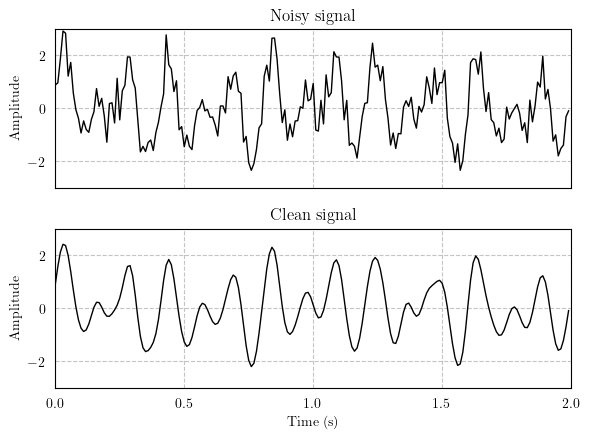

In [3]:
np.random.seed(0)  # For reproducibility

# --- Signal Parameters ---
frequency = 5  # Hz
amplitude = 1.0
sampling_rate = 100  # Samples per second
duration = 2  # Seconds

# --- Generate Time Vector ---
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# --- Generate Clean Sine Wave (sum of two frequencies for more complexity) ---
clean_signal = amplitude * np.sin(2 * np.pi * frequency * t) + amplitude * np.sin(2 * np.pi * frequency * 1.5 * t)

# --- Generate Noise ---
# Mean of the Gaussian noise (typically 0 for white noise)
noise_mean = 0
# Standard deviation of the Gaussian noise (controls noise intensity)
noise_std_dev = 0.5
noise = np.random.normal(noise_mean, noise_std_dev, len(t))

# --- Add Noise to Signal ---
noisy_signal = clean_signal + noise

# --- Butterworth Low-pass Filter Design ---
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.25 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# --- Filter Parameters ---
cutoff = 7  # Hz, just above the signal frequency
order = 4

# --- Apply Low-pass Filter to Noisy Signal ---
filtered_signal = butter_lowpass_filter(noisy_signal, cutoff, sampling_rate, order)


# --- Plotting to match the pasted image ---
fig, axs = plt.subplots(nrows=2, figsize=(6, 4.5), sharex=True, sharey=True)

axs[0].plot(t, noisy_signal, 'k', linewidth=1, zorder=25)
axs[0].set_title('Noisy signal')
axs[0].set_ylabel('Amplitude')

axs[1].plot(t, filtered_signal, 'k', linewidth=1, zorder=25)
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Clean signal')

for ax in axs:
    ax.set_xlim(0, duration)
    ax.set_ylim(-3, 3)
    ax.set_xticks(np.arange(0, duration + 0.5, 0.5))
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/signal_illustration.pdf", dpi=DPI, transparent=True)
plt.show()

### Signals

In [4]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [5]:
raw_signals = pd.read_pickle(f"{DATA_DIR}/raw_signals.pkl")
crsp = pd.read_pickle(f"{DATA_DIR}/crsp.pkl")

In [6]:
subset = [
    "UNITED AIR LINES INC",
    "APPLE COMPUTER INC",
    "APPLE INC",
    "FORD MOTOR CO",
    "FORD MOTOR CO DEL",
    "WALMART INC",
    "AMERICAN TELEPHONE & TELEG CO",
]

In [7]:
crsp[crsp["comnam"].isin(subset)].xs("2024-12-31")

,comnam,ret,shrout,vol,prc,altprc,exchcd,siccd,ticker,cusip,exchange,industry,ret_adj,excess_ret,dollar_vol,mktcap
permno,,,,,,,,,,,,,,,,
14593,APPLE INC,0.055155,15115823.0,9710426.0,250.42,250.42,3,3571,AAPL,03783310,NASDAQ,Manufacturing,0.055155,0.051455,2431684878.92,3785304395.66
25785,FORD MOTOR CO DEL,-0.110512,3903437.0,12187469.0,9.9,9.9,1,3711,F,34537086,NYSE,Manufacturing,-0.110512,-0.114212,120655943.1,38644026.3
55976,WALMART INC,-0.021,8033386.0,3821318.0,90.35,90.35,1,5311,WMT,93114210,NYSE,Retail,-0.021000,-0.0247,345256081.3,725816425.1


In [8]:
id_mapping = {
    "Apple Inc.": 14593,
    "Walmart Inc": 55976,
}

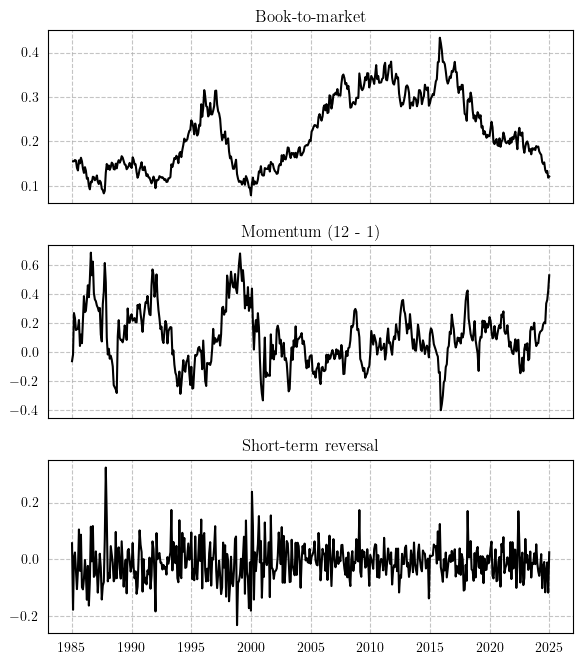

In [9]:
sig = {"b2m": "Book-to-market", "mom_12_1": "Momentum (12 - 1)", "strev": "Short-term reversal"}
_id = 55976  # Walmart Inc.
start_dt = datetime(1984, 12, 31)
fig, axs = plt.subplots(nrows=len(sig), figsize=(6, 2.25 * len(sig)), sharex=True, sharey=False)

for ax, s in zip(axs, sig):
    s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)[s].dropna()
    ax.plot(s_vals, c="black")
    # ax.set_xlim(0, duration)
    # ax.set_ylim(-3, 3)
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.set_title(sig[s])
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/inv_signal_example.pdf", dpi=DPI, transparent=True)
plt.show()

In [10]:
# https://www.mathworks.com/help/ident/ref/iddata.detrend.html

<Axes: >

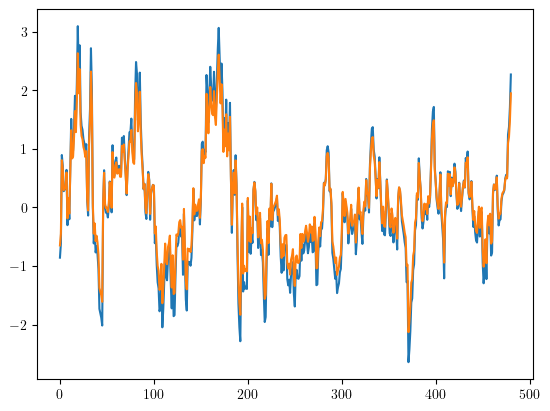

In [11]:
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, Normalizer, KernelCenterer

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = StandardScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"].dropna()
transformer = RobustScaler().fit(s_vals.to_frame().dropna())
pd.Series(transformer.transform(s_vals.to_frame().dropna()).flatten()).plot()

In [12]:
from arch import arch_model



In [13]:
mdl = arch_model(s_vals, vol='Garch', p=1, o=0, q=1)
res = mdl.fit(disp="off")
print(res.summary())
forecasts = res.forecast()
# forecasts.mean

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               mom_12_1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                254.332
Distribution:                  Normal   AIC:                          -500.664
Method:            Maximum Likelihood   BIC:                          -483.961
                                        No. Observations:                  481
Date:                Sun, Jul 27 2025   Df Residuals:                      480
Time:                        16:31:38   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0855  1.569e-02      5.450  5.048e-08 [5.476e-0

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [14]:
from arch import arch_model
mdl = arch_model(s_vals, vol='Garch', p=1, o=0, q=1)
res = mdl.fit(disp="off")
res.conditional_volatility

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03576. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


1984-12-31    0.215461
1985-01-31    0.164643
1985-02-28    0.125950
1985-03-31    0.179285
1985-04-30    0.159941
                ...   
2024-08-31    0.131133
2024-09-30    0.127920
2024-10-31    0.232622
2024-11-30    0.262170
2024-12-31    0.316881
Freq: ME, Name: cond_vol, Length: 481, dtype: float64

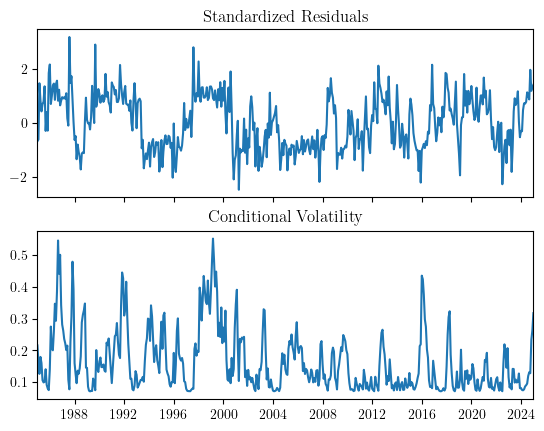

In [15]:
res.plot()
plt.show()

<Axes: >

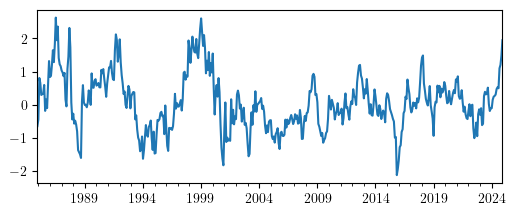

In [16]:
s_vals = raw_signals.loc[start_dt:].xs(_id, level=1)["mom_12_1"]
transformer = RobustScaler().fit(s_vals.to_frame())
pd.Series(transformer.transform(s_vals.to_frame()).flatten(), index=s_vals.index).plot(figsize=(6, 2.25))

### Use the below to simulate signals

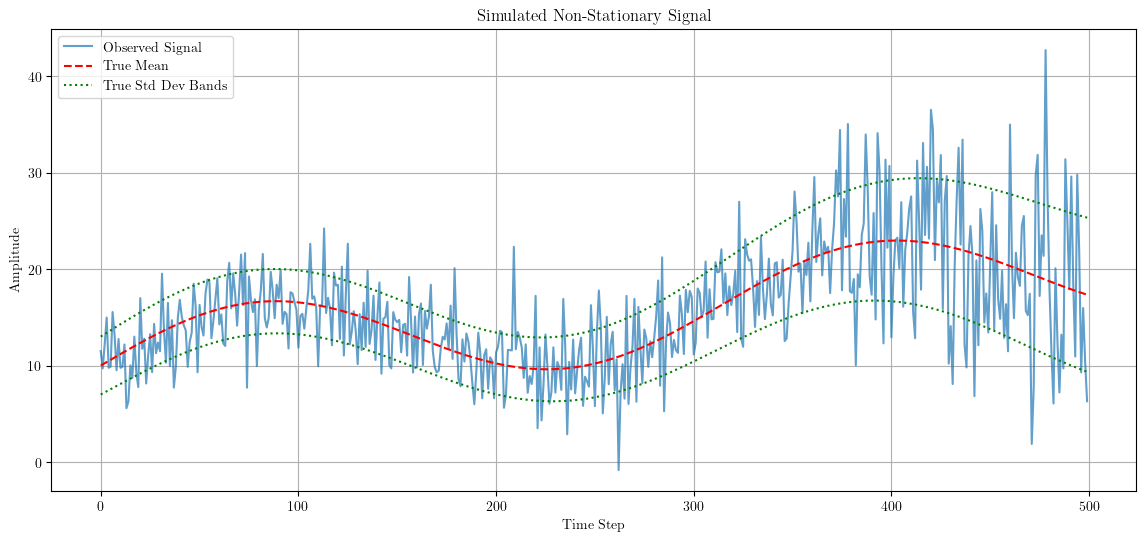

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# --- 1. Simulate a Non-Stationary Signal (same as before) ---
np.random.seed(42)
time_points = 500
t = np.arange(time_points)
true_mean = 10 + 5 * np.sin(t / 50) + 0.02 * t
true_std_dev = 2 + 1 * np.cos(t / 80) + 0.01 * t
true_variance = true_std_dev**2
signal = np.random.normal(loc=true_mean, scale=true_std_dev, size=time_points)

plt.figure(figsize=(14, 6))
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, true_mean + true_std_dev, 'g:', label='True Std Dev Bands')
plt.plot(t, true_mean - true_std_dev, 'g:')
plt.title('Simulated Non-Stationary Signal')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


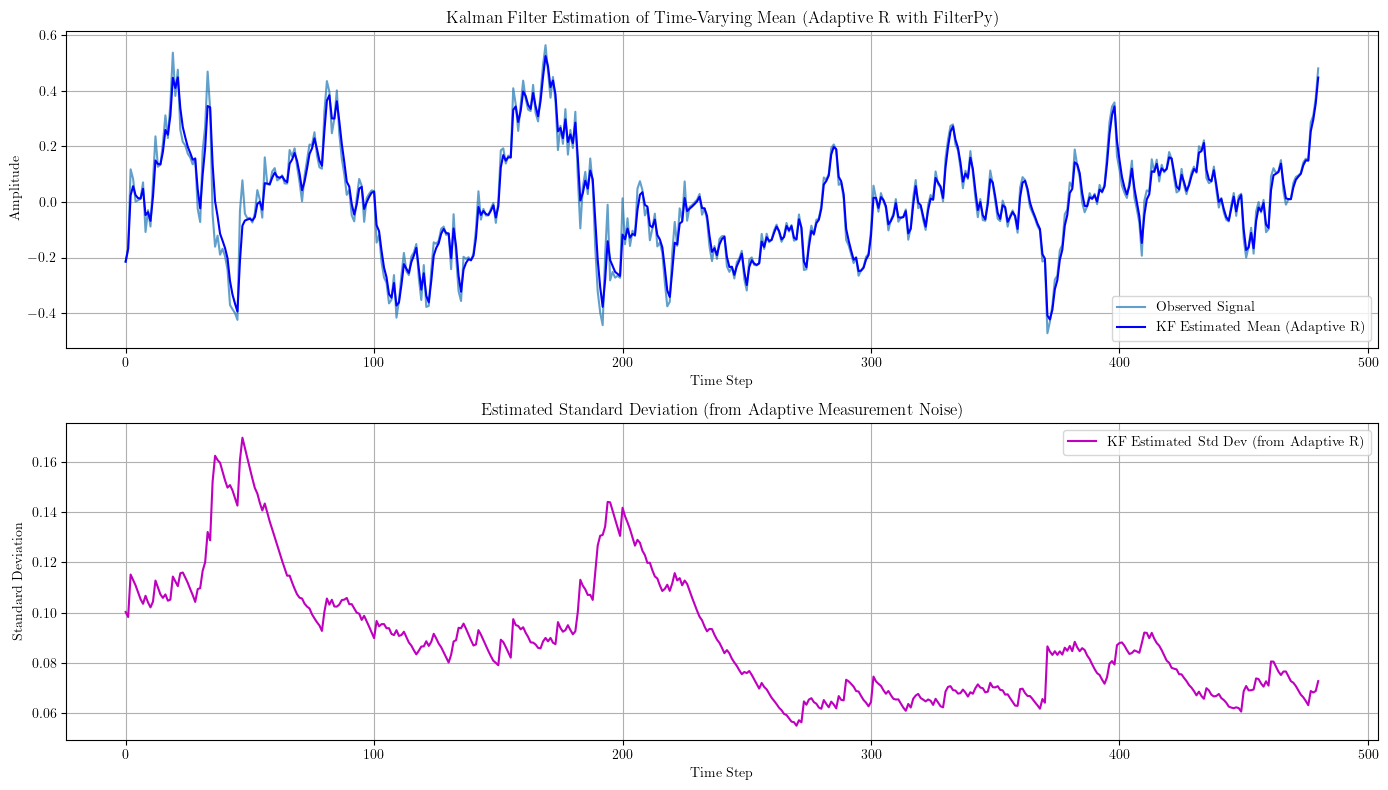

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# --- 1. Simulate a Non-Stationary Signal (same as before) ---
np.random.seed(42) # For reproducibility

time_points = len(s_vals)
t = np.arange(time_points)

# Generate the signal
signal = detrend(s_vals)


# --- 2. Implement the Adaptive Kalman Filter using filterpy ---

# Initialize the KalmanFilter object
# State dimension (dim_x) = 1 (for mean)
# Measurement dimension (dim_z) = 1 (for signal sample)
kf = KalmanFilter(dim_x=1, dim_z=1)

# Initial state estimation (x) and its covariance (P)
kf.x = np.array([[signal[0]]]) # Initial estimate of the mean
kf.P = np.array([[100.0]])   # High initial uncertainty in mean estimate

# State transition function (F)
# Mean follows a random walk, so F is just 1
kf.F = np.array([[1.]])

# Measurement function (H)
# Observation is directly the mean, so H is just 1
kf.H = np.array([[1.]])

# Process noise covariance (Q)
# Represents how much the true mean is allowed to change between steps
# Tune this value: larger Q means filter trusts new measurements more.
Q_mu_scalar = 0.01 # Same as Q_mu from previous examples
kf.Q = np.array([[Q_mu_scalar]])

# Adaptive R_k parameters
# Initial estimate of measurement noise covariance (R_k)
# Use variance of initial segment as a start
R_k_scalar = np.var(signal[:12])
kf.R = np.array([[R_k_scalar]]) # Set initial R for the filter

alpha_R = .05 # Smoothing factor for R_k adaptation (0 to 1)
# alpha_R = 0.10 # Smoothing factor for R_k adaptation (0 to 1)

# Store results
mean_estimates = [kf.x[0,0]] # Initial mean estimate
std_dev_estimates = [] # We'll derive this from the adaptive R_k

# Main Kalman Filter Loop
for i in range(1, time_points):
    z_k = signal[i] # Current observation

    # --- Prediction Step ---
    kf.predict()

    # --- Update Step ---
    kf.update(z_k)

    # Store estimated mean
    mean_estimates.append(kf.x[0,0])

    # --- Adapt R_k (Measurement Noise Covariance) ---
    # The innovation (measurement residual) for the current step is stored in kf.y
    innovation = kf.y[0,0]

    # Update R_k using EWMA of squared innovations
    R_k_scalar = alpha_R * (innovation**2) + (1 - alpha_R) * R_k_scalar
    kf.R = np.array([[R_k_scalar]]) # Update filter's R for the next iteration

    # Store the square root of R_k as our estimated standard deviation
    std_dev_estimates.append(np.sqrt(R_k_scalar))

# Pad std_dev_estimates for the initial point (since it starts from i=1)
std_dev_estimates.insert(0, np.sqrt(np.var(signal[:12]))) # Use initial R_k's sqrt

# --- 3. Plotting Results ---
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Observed Signal', alpha=0.7)
# plt.plot(t, true_mean, 'r--', label='True Mean')
plt.plot(t, mean_estimates, 'b-', label='KF Estimated Mean (Adaptive R)')
plt.title('Kalman Filter Estimation of Time-Varying Mean (Adaptive R with FilterPy)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
# plt.plot(t, true_std_dev, 'r--', label='True Standard Deviation')
plt.plot(t, std_dev_estimates, 'm-', label='KF Estimated Std Dev (from Adaptive R)')
plt.title('Estimated Standard Deviation (from Adaptive Measurement Noise)')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

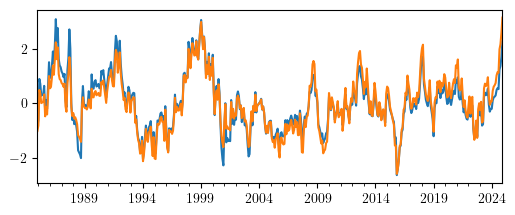

In [54]:
s_vals.sub(s_vals.mean()).div(s_vals.std()).plot(figsize=(6, 2.25))
xx = pd.Series(detrend(s_vals), index=s_vals.index).div(pd.Series(std_dev_estimates, index=s_vals.index))
xx.div(xx.std()).plot(figsize=(6, 2.25))
plt.show()

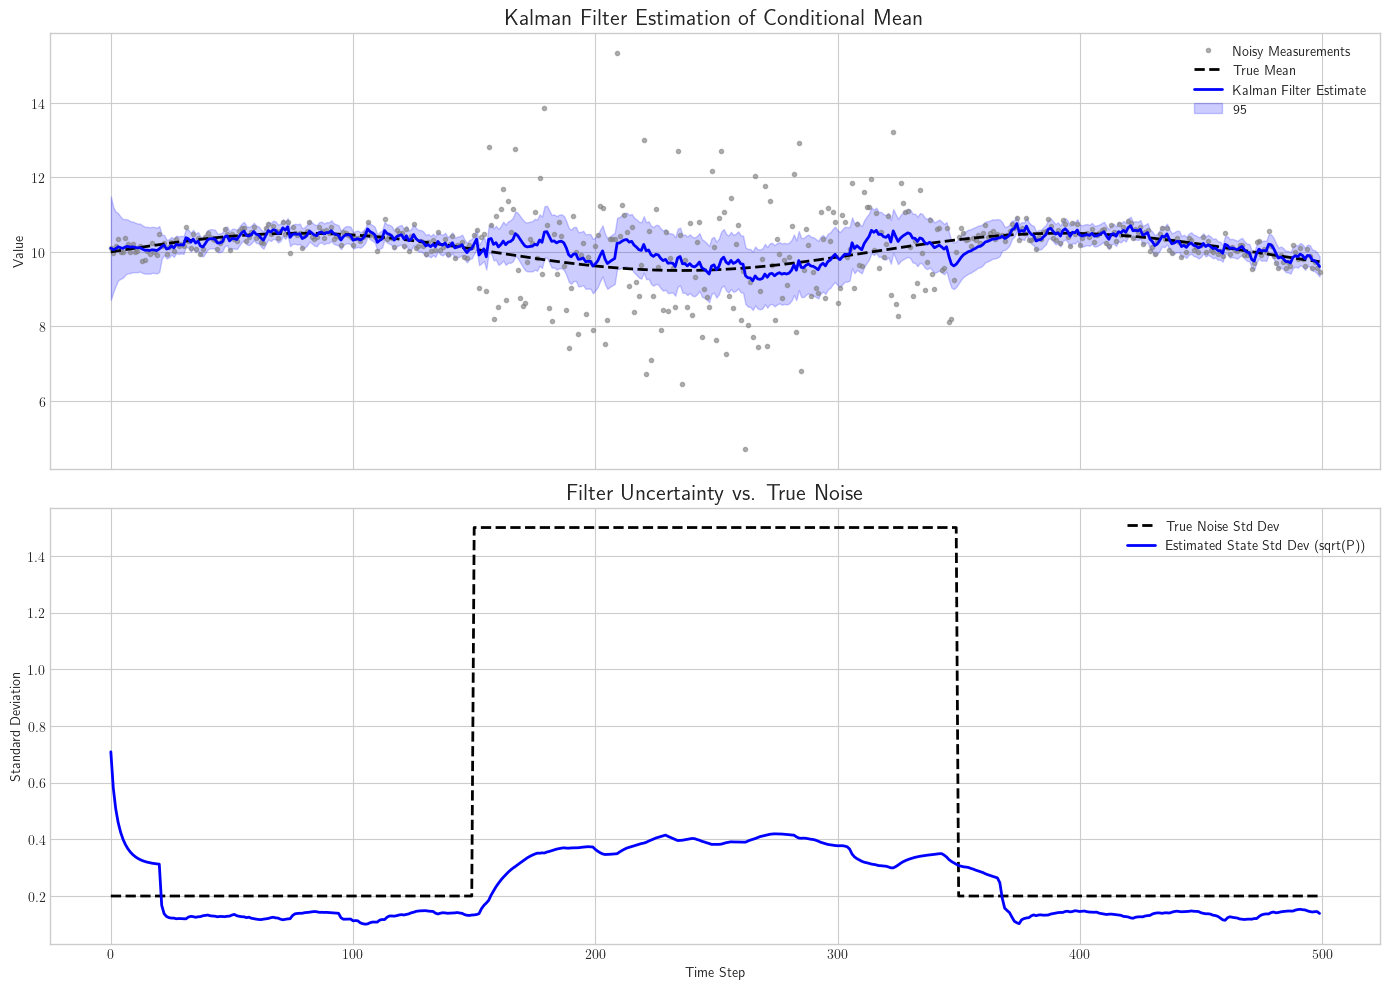

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# For reproducibility
np.random.seed(42)

## ---------------------------------------------------
## Step 1: Generate Synthetic Heteroscedastic Data
## ---------------------------------------------------
# The data will have a true mean that follows a sine wave and two noise regimes.
n_samples = 500
dt = 0.1

# True underlying mean
true_mean = 0.5 * np.sin(np.arange(n_samples) * dt * 0.2) + 10

# Create heteroscedastic noise (low noise -> high noise -> low noise)
noise_std = np.ones(n_samples) * 0.2  # Low noise regime
noise_std[150:350] = 1.5             # High noise regime
noise = np.random.randn(n_samples) * noise_std

# Create the final measured time series
measurements = true_mean + noise

## ---------------------------------------------------
## Step 2: Initialize the Kalman Filter
## ---------------------------------------------------
# We are tracking one variable (the mean), so dim_x=1
# We are measuring one variable (the value), so dim_z=1
kf = KalmanFilter(dim_x=1, dim_z=1)

# Define the model matrices
kf.x = np.array([measurements[0]])  # Initial state (mean)
kf.P = np.array([[1.]])             # Initial state covariance (uncertainty)
kf.F = np.array([[1.]])             # State transition matrix
kf.H = np.array([[1.]])             # Measurement function
kf.Q = np.array([[0.01]])           # Process noise (how much we expect the mean to change)
# kf.R will be updated dynamically in the loop

## ---------------------------------------------------
## Step 3: Run the Filter and Adapt R
## ---------------------------------------------------
# Lists to store results
estimated_means = []
estimated_variances = []
residuals = []
residual_window_size = 20 # Window to estimate R

for z in measurements:
    # Predict the next state
    kf.predict()

    # Update the filter with the new measurement
    kf.update(z)

    # Store the results
    estimated_means.append(kf.x[0])
    estimated_variances.append(kf.P[0, 0])

    # --- Adaptive R Estimation ---
    # Calculate the residual (innovation)
    residual = z - kf.H @ kf.x_prior
    residuals.append(residual[0])
    
    # Use a moving window of residuals to estimate R for the *next* step
    if len(residuals) > residual_window_size:
        # Variance of recent residuals is a good estimate for R
        # Add a small epsilon for numerical stability
        r_est = np.var(residuals[-residual_window_size:]) + 1e-6 
        kf.R = np.array([[r_est]])

# Convert lists to numpy arrays for plotting
estimated_means = np.array(estimated_means)
estimated_variances = np.array(estimated_variances)
estimated_std = np.sqrt(estimated_variances)

## ---------------------------------------------------
## Step 4: Visualize the Results
## ---------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Mean Estimation
ax1.plot(measurements, 'o', markersize=3, color='gray', alpha=0.6, label='Noisy Measurements')
ax1.plot(true_mean, 'k--', lw=2, label='True Mean')
ax1.plot(estimated_means, color='b', lw=2, label='Kalman Filter Estimate')
ax1.fill_between(
    range(n_samples),
    estimated_means - 1.96 * estimated_std,
    estimated_means + 1.96 * estimated_std,
    color='b',
    alpha=0.2,
    label='95% Confidence Interval'
)
ax1.set_title('Kalman Filter Estimation of Conditional Mean', fontsize=16)
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)

# Plot 2: Uncertainty (Standard Deviation)
ax2.plot(noise_std, 'k--', lw=2, label='True Noise Std Dev')
ax2.plot(estimated_std, color='b', lw=2, label='Estimated State Std Dev (sqrt(P))')
ax2.set_title('Filter Uncertainty vs. True Noise', fontsize=16)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Standard Deviation')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Signal filtering

In [337]:
x = pd.Series(detrend(s_vals), index=s_vals.index)
x = x.sub(x.mean()).div(x.std())  # TODO: to be replace by proper LNA

n = len(x)
fhat = fft.rfft(x.values, n)
f, Pxx_den = signal.periodogram(x, 10e3, scaling='density')

# Clustering the frequency domain representation
cat = MiniBatchKMeans(n_clusters=2, n_init="auto", init="k-means++", random_state=1234).fit(Pxx_den.reshape(-1, 1))
filt_val = cat.cluster_centers_.flatten().argmax()
filt_flags = cat.labels_ == filt_val
filt_fhat = np.where(filt_flags, fhat, 0)
filt_x = fft.irfft(filt_fhat, n=n)

c:\Users\franc\anaconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


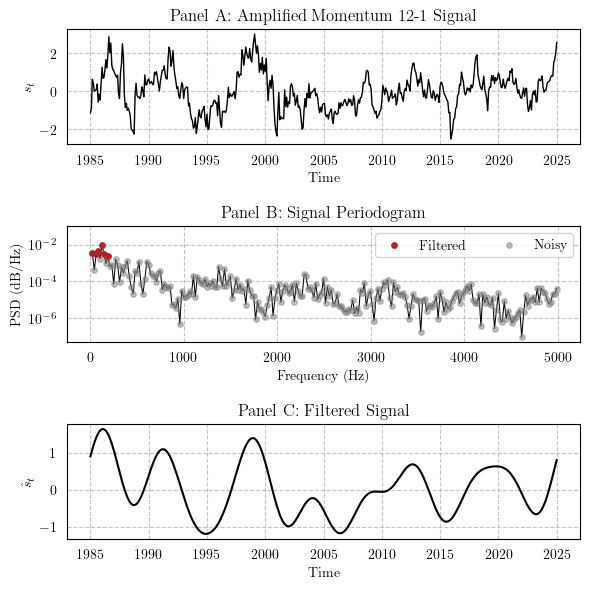

In [345]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 6), sharex=False, sharey=False)

# Raw signal
axs[0].plot(x.index, x.values, 'k', linewidth=1, zorder=25)

# Periodogram

axs[1].scatter(f[filt_flags], Pxx_den[filt_flags], color='firebrick', s=15, zorder=25)
axs[1].scatter(f[~filt_flags], Pxx_den[~filt_flags], c="gray", s=15, zorder=25, alpha=0.5)
axs[1].legend(["Filtered", "Noisy"], ncols=2, loc='upper right', fontsize=10)
axs[1].semilogy(f[1:], Pxx_den[1:], 'k', linewidth=.75, zorder=20)
axs[1].set_ylim([5e-8, 1E-1])

# Filtered signal
axs[2].plot(x.index, filt_x, 'k', linewidth=1.5, zorder=25)

for ax in axs:
    ax.grid(ls='--', alpha=0.75, zorder=-25)
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

axs[0].set_xlabel("Time")
axs[1].set_xlabel("Frequency (Hz)")
axs[2].set_xlabel("Time")
axs[0].set_ylabel("$s_{t}$")
axs[1].set_ylabel("PSD (dB/Hz)")
axs[2].set_ylabel("$\hat{s}_{t}$")
axs[0].set_title("Panel A: Amplified Momentum 12-1 Signal")
axs[1].set_title("Panel B: Signal Periodogram")
axs[2].set_title("Panel C: Filtered Signal")

plt.tight_layout(h_pad=1.5)
plt.savefig(f"{DIR}/signal_fft.pdf", dpi=DPI, transparent=True)
plt.show()